## Programming Exercise 3: Multi-class Classification and Neural Networks
#### Author - Rishabh Jain

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

from scipy.io import loadmat

### 1&nbsp;&nbsp;&nbsp;&nbsp;Multi-class Classification

##### Problem Statement
For this exercise, we will use **logistic regression** and **neural networks** to recognize handwritten digits (from 0 to 9). In this part of the exercise we will extend our previous implementation of logistic regression and apply it to one-vs-all classification.

#### 1.1&nbsp;&nbsp;&nbsp;&nbsp;Dataset
We are given a dataset in ex3data.mat that contains 5000 training examples of handwritten digits, where each training example is a 20 X 20 pixel grayscale image of the digit. Each pixel is repsented by a floating point number indicating the grayscale intensity at that location.  

This 20 by 20 pixel grid is "unrolled" into 400-dimensional vector. Each of these training examples become a single row in our dataset. This gives us a 5000 X 400 design matrix X where every row is a training example for a handwritten digit image. The second part of the training set is a 5000-dimnesional vectory y that contains labels for the training set

In [2]:
# Loading Mat file
mat=loadmat('./ex3data1.mat')
m,n=mat['X'].shape
print(*mat.keys(),sep='\n')

__header__
__version__
__globals__
X
y


In [3]:
# Loading data from mat to Dataframe
data=pd.DataFrame()
for i in range(n):
    data[f'x{i+1}']=mat['X'].T[i]
data['y']=mat['y']
print('TRAINING DATASET SHAPE : {0} X {1}'.format(*data.shape))
data.sample(5)

TRAINING DATASET SHAPE : 5000 X 401


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x392,x393,x394,x395,x396,x397,x398,x399,x400,y
1472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,2
105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,10
3053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000043,-0.006367,-0.001213,0.000106,0.0,0.0,0.0,0.0,0.0,6
3587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,7
3333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,6


#### 1.2&nbsp;&nbsp;&nbsp;&nbsp;Visualizing the data
We will begin by visualizing a subset of the training set. We will randomly select 100 rows from X. This function maps each row to a 20 X 20 pixel image and displays together.

In [4]:
def displayData(X):
    m,n=X.shape
    width=int(np.sqrt(n))
    height=int(n/width)
    rows=int(np.floor(np.sqrt(m)))
    cols=int(np.ceil(m/rows))
    totalWidth=cols+cols*width
    displayArray=np.zeros((1,totalWidth))
    rowPadding=np.ones((1,totalWidth))
    colPadding=np.ones((height,1))
    index=0
    for i in range(rows):
        row=colPadding*0
        for j in range(cols):
            if index<m:
                x=X[index].reshape((width,height)).T
                index=index+1
            else:
                x=np.zeros((width,height)).T
            row=np.column_stack((row,x))
            if j<cols-1:
                row=np.column_stack((row,colPadding))
        displayArray=np.row_stack((displayArray,row))
        if i<rows-1:
            displayArray=np.row_stack((displayArray,rowPadding))
    displayArray=np.row_stack((displayArray,rowPadding*0))
    plt.imshow(displayArray)
    plt.axis('off')

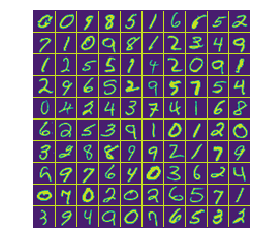

In [5]:
displayData(data.sample(100).iloc[:,:-1].values)